# **Visual Logo Recognition Contest**
VISION AND COGNITIVE SERVICES A.Y. 2020/2021

The aim of the contest is to retrieve the most similar images representing logos of famous companies from a database set containing 110 images. We will consider 4 query images and use the SIFT algorithm. The performance of the model will be evaluated using precision, recall and average precision metrics for each for the query logos.
You can modify the baseline (parameters, feature matching technique, ...) and send your results.

- [Send your results](https://forms.gle/GTrXtqcTpFC6g14P6)
- [Visualize rank](https://docs.google.com/spreadsheets/d/e/2PACX-1vRFd6yf-OHsrtlONu6i_0Yu2FRBItV8qSzxi_PSp_MtuGaxgM-_0fzSyvyNjKC01IBI3Uyft32pF4hT/pubhtml)

In [ ]:
%%capture
!pip uninstall opencv-python -y
# Change OpenCV version since patented and experimental algorithms
# are contained in opencv_contrib package
!pip install opencv-contrib-python --force-reinstall

In [ ]:
%%capture
!unzip query.zip
!unzip database.zip

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# List of query/database images
query_images = []
db_images = []
logo_names = []

# Resize images
img_size = (400, 400)

# Read query images
# Order by name
query_dir = sorted(os.listdir('query/'))
for idx, img_name in enumerate(query_dir):
  # Read image
  img = cv2.imread(os.path.join('query/', img_name))
  # Resize image
  img = cv2.resize(img, dsize=img_size)
  # Save image
  query_images.append(img)
  # Save logo names (remove "_logo.txt" and capitalize)
  logo_names.append(os.path.splitext(img_name)[0][:-5].capitalize())
  #print("Image '" + img_name + "' loaded.")
print("Query images loaded!") 

# Read db images
# Order by number
db_dir = sorted(os.listdir('database/'), key=lambda x: int(x.split('.')[0]))
for idx, img_name in enumerate(db_dir):
  # Read image
  img = cv2.imread(os.path.join('database/', img_name))
  # Resize image
  img = cv2.resize(img, dsize=img_size)
  # Save image
  db_images.append(img)
  #print("Image '" + img_name + "' loaded.")
print("Database images loaded!") 

Query images loaded!
Database images loaded!


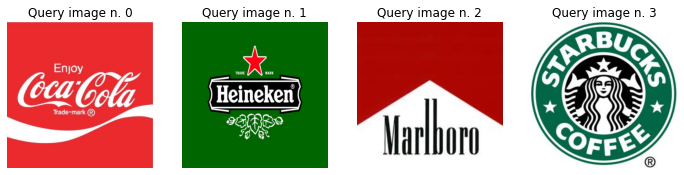

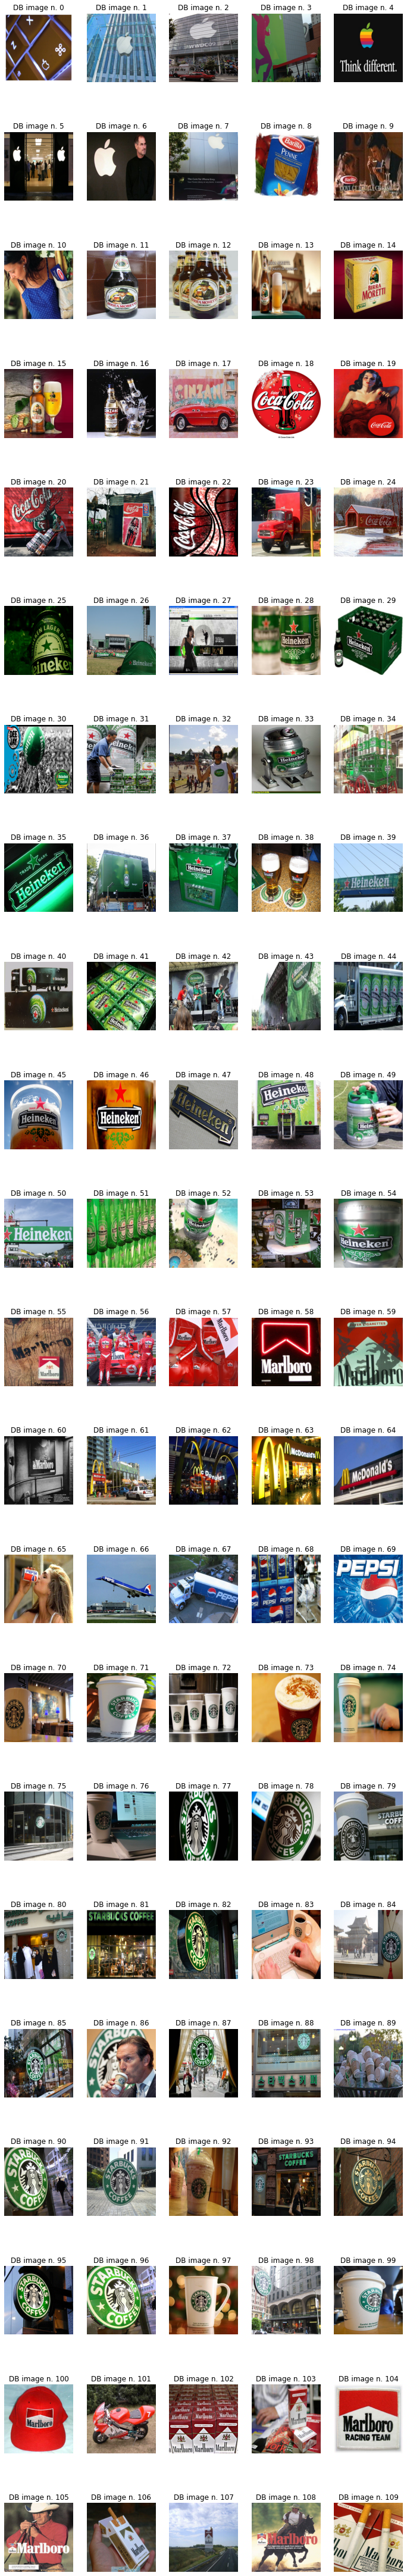

In [ ]:
# Plot query images
fig = plt.figure(figsize=(12,12))
for i in range(len(query_images)):
  _ = plt.subplot(1, len(query_images), i+1), plt.title("Query image n. " + str(i))
  plt.imshow(cv2.cvtColor(query_images[i], cv2.COLOR_BGR2RGB)), plt.axis('off')

# Plot database images
fig = plt.figure(figsize=(12, 80))
for i in range(len(db_images)):
  _ = plt.subplot(len(db_images)/5, 5, i+1), plt.title("DB image n. " + str(i))
  plt.imshow(cv2.cvtColor(db_images[i], cv2.COLOR_BGR2RGB)), plt.axis('off')

In [ ]:
# # Ground-truth arrays per logo
coca_cola_GT = np.zeros(len(db_images))
marlboro_GT = np.zeros(len(db_images))
starbucks_GT = np.zeros(len(db_images))
heineken_GT = np.zeros(len(db_images))

coca_cola_GT[18:25] = 1
marlboro_GT[55:61] = 1
marlboro_GT[100:] = 1
starbucks_GT[70:100] = 1
heineken_GT[25:55] = 1

# Matrix containing ground-truth values for each query image
GT_matrix = np.vstack([coca_cola_GT, heineken_GT, marlboro_GT, starbucks_GT])
print(f"GT matrix shape: {GT_matrix.shape}")

n_coca_cola = int(coca_cola_GT.sum())
n_heineken = int(heineken_GT.sum())
n_marlboro = int(marlboro_GT.sum())
n_starbucks = int(starbucks_GT.sum())
n_others = len(db_images) - (n_coca_cola + n_heineken + n_marlboro + n_starbucks)
print(f"Number of database images (coca_cola): {n_coca_cola}")
print(f"Number of database images (heineken): {n_heineken}")
print(f"Number of database images (marlboro): {n_marlboro}")
print(f"Number of database images (starbucks): {n_starbucks}")
print(f"Number of database images (others): {n_others}")
# print(GT_matrix)

GT matrix shape: (4, 110)
Number of database images (coca_cola): 7
Number of database images (heineken): 30
Number of database images (marlboro): 16
Number of database images (starbucks): 30
Number of database images (others): 27


SIFT algorithm (default parameters) 

In [ ]:
# Define SIFT detector object
detector = cv2.xfeatures2d.SIFT_create(sigma = 1.1, nfeatures = 1200, contrastThreshold = 0.04, edgeThreshold = 10)

# Detect and compute interest points and their descriptors
query_kps = []
query_des = []
db_kps = []
db_des = []

for i in range(len(query_images)):  
  kp, des = detector.detectAndCompute(query_images[i], None)
  query_kps.append(kp)
  query_des.append(des)

for i in range(len(db_images)):  
  kp, des = detector.detectAndCompute(db_images[i], None)
  db_kps.append(kp)
  db_des.append(des)

Ratio test

In [ ]:
# Brute-force matcher 
bf = cv2.BFMatcher_create(cv2.NORM_L2)

# Matrix containing the number of matches per logo
num_matches = np.zeros((len(query_images), len(db_images)))

# Filter matches using the Lowe's ratio test
ratio_thresh = 0.84

# Save  matches for each descriptor of query images
logo_matches = [] # List of lists

# For each query image
for q in range(len(query_images)):
  q_matches = []
  # For each database image
  for db in range(len(db_images)):
    matches = bf.knnMatch(query_des[q], db_des[db], k=2)  
    # Apply ratio test
    n_matches = 0
    sel_matches = []
    for m,n in matches:
      if m.distance < ratio_thresh * n.distance:
        n_matches += 1
        sel_matches.append(m)
    # Save number of matches
    num_matches[q, db] = n_matches
    # Save matches
    q_matches.append(sel_matches)
  logo_matches.append(q_matches)

for idx, logo in enumerate(logo_names):
  print("Number of matches (" + logo + "):")
  print(num_matches[idx])

Number of matches (Cocacola):
[ 36.  42.  36.  30.  68.  52.  52.  43.  67.  56.  52.  47.  34.  38.
  33.  38.  48.  42. 102.  78.  71.  54.  59.  45.  68.  63.  41.  50.
  71.  59.  49.  30.  39.  60.  31.  67.  75.  61.  54.  57.  67.  14.
  49.  37.  34.  55.  38.  61.  59.  40.  69.  29.  64.  54.  62.  41.
  46.  33.  61.  69.  30.  28.  65.  58.  46.  51.  45.  48.  41.  37.
  63.  56.  30.  42.  35.  37.  41.  50.  74.  63.  63.  54.  59.  28.
  61.  28.  39.  31.  31.  33.  48.  52.  42.  40.  37.  43.  32.  47.
  67.  33.  33.  48.  45.  64.  43.  53.  49.  43.  68.  39.]
Number of matches (Heineken):
[ 73.  32.  30.  34.  37.  30.  36.  43.  64.  44.  40.  44.  28.  39.
  37.  20.  40.  31.  40.  39.  42.  56.  29.  33.  59.  93.  72.  51.
 215. 123.  57.  81.  47. 131.  53.  99.  27. 126.  71.  80.  61.  60.
  77.  29.  36. 129. 114.  54. 166.  94. 125.  46.  67. 148. 122.  45.
  42.  33.  88.  39.  41.  27.  43.  36.  49.  48.  49.  30.  29.  47.
  38.  41.  30.  42.  42. 

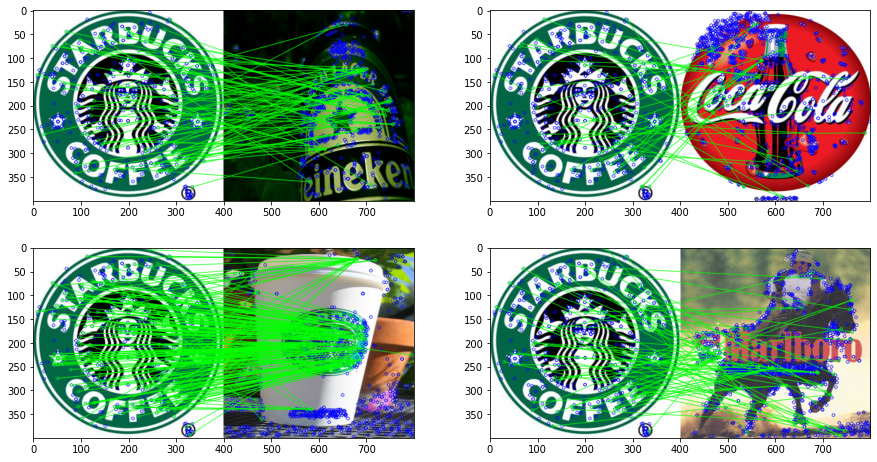

In [ ]:
# Draw some matches
_  = plt.figure(figsize=(15, 8))
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=0)
plt_list = [25, 18, 71, 108]
for idx, n in enumerate(plt_list):
  img_matches = cv2.drawMatches(query_images[3], query_kps[3], db_images[n], db_kps[n], logo_matches[3][n], None, **draw_params)
  _ = plt.subplot(2, 2, idx+1), plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))

# **Performance Evaluation**

The performance of the model will be evaluated in terms of precision, recall and average precision.

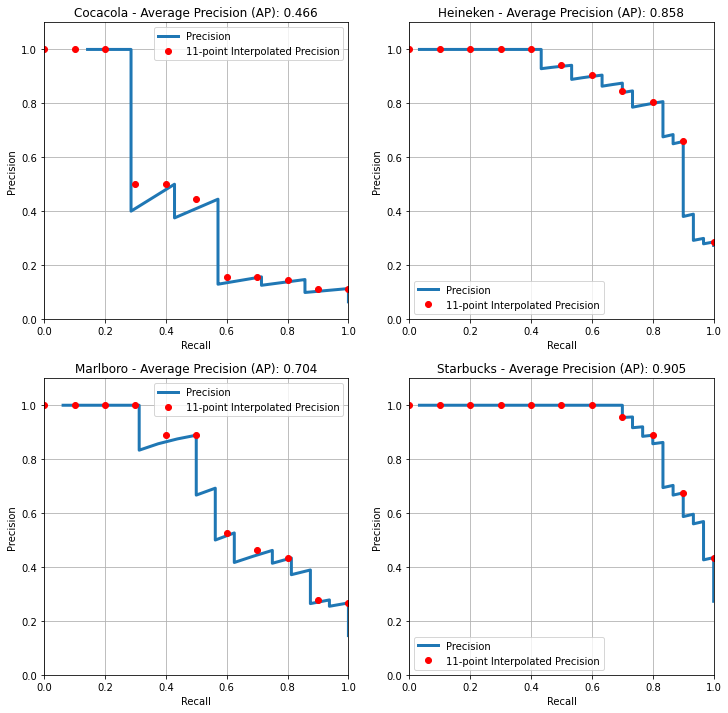

In [ ]:
# Average precision for each logo
AP_all = np.zeros(len(query_images))

_ = plt.figure(figsize=(12, 12))
for i in range(len(query_images)):
  # Rank images in descending order according to the number of detected matches
  idx = np.argsort(-num_matches[i])

  # True Positives
  TP = GT_matrix[i, idx] == 1

  # False Positives
  FP = GT_matrix[i, idx] == 0

  # TP and FP for each k
  TP = np.cumsum(TP)
  FP = np.cumsum(FP)

  # Precision/Recall for each k
  prec = TP / (TP + FP);
  rec = TP / np.sum(GT_matrix[i]);
  
  # (Interpolated) Average precision (as in Pascal VOC2008)
  AP = 0;
  interp_prec = []
  # We evaluate the precision at 11 recall values to reduce ''wiggles'' in the precision/recall curve
  for t in np.linspace(0, 1, num=11): 
    p = prec[rec >= t]
    if p.size == 0:
      p = 0
    else:
      p = p.max()
    interp_prec.append(p)
    AP = AP + p/11
  AP_all[i] = AP

  # Plot precision/recall
  _ = plt.subplot(2, 2, i+1)
  plt.title(f"{logo_names[i]} - Average Precision (AP): {AP:.3f}")
  _ = plt.plot(rec, prec, '-', linewidth=3) 
  _ = plt.plot(np.linspace(0, 1, num=11), interp_prec, 'o', color='red', linewidth=2)
  plt.legend(['Precision', '11-point Interpolated Precision'])
  plt.grid('on')
  plt.xlabel('Recall'), plt.ylabel('Precision')
  plt.axis((0,1,0,1.1))

In [ ]:
# Print results
for i in range(len(query_images)):
  print(f"{logo_names[i]} - Average Precision (AP): {AP_all[i]:.3f}")

print(f"\nmAP: {np.mean(AP_all):.3f}") 

Cocacola - Average Precision (AP): 0.466
Heineken - Average Precision (AP): 0.858
Marlboro - Average Precision (AP): 0.704
Starbucks - Average Precision (AP): 0.905

mAP: 0.733


In [ ]:
# parameters for each query image

sig = [2.5, 1.2, 1.1, 1.2]          # sigma
n_feat = [1500, 1500, 1500, 1200]   # n_features
edge_t = [17, 5, 45, 8]             # edgeThreshold
cont_t = [0.004, 0.004, 0.04, 0.04] # contrastThreshold
thr = [0.8, 0.74, 0.67, 0.84]       # ratio_threshold


In [ ]:
best_AP = np.zeros(len(query_images))



for k in range(len(query_images)):
  # Define SIFT detector object
  detector = cv2.xfeatures2d.SIFT_create(sigma = sig[k], nfeatures = n_feat[k], contrastThreshold = cont_t[k], edgeThreshold = edge_t[k] )

  # Detect and compute interest points and their descriptors
  query_kps = []
  query_des = []
  db_kps = []
  db_des = []

  for i in range(len(query_images)):  
    kp, des = detector.detectAndCompute(query_images[i], None)
    query_kps.append(kp)
    query_des.append(des)

  for i in range(len(db_images)):  
    kp, des = detector.detectAndCompute(db_images[i], None)
    db_kps.append(kp)
    db_des.append(des)
  # Brute-force matcher 
  bf = cv2.BFMatcher_create(cv2.NORM_L2)

  # Matrix containing the number of matches per logo
  num_matches = np.zeros((len(query_images), len(db_images)))

  # Filter matches using the Lowe's ratio test
  ratio_thresh = thr[k]

  # Save  matches for each descriptor of query images
  logo_matches = [] # List of lists

  # For each query image
  for q in range(len(query_images)):
    q_matches = []
    # For each database image
    for db in range(len(db_images)):
      matches = bf.knnMatch(query_des[q], db_des[db], k=2)  
      # Apply ratio test
      n_matches = 0
      sel_matches = []
      for m,n in matches:
        if m.distance < ratio_thresh * n.distance:
          n_matches += 1
          sel_matches.append(m)
      # Save number of matches
      num_matches[q, db] = n_matches
      # Save matches
      q_matches.append(sel_matches)
    logo_matches.append(q_matches)

  
  print("Number of matches (" + logo_names[k] + "):")
  print(num_matches[k])
  # Average precision for each logo
  AP_all = np.zeros(len(query_images))

  for i in range(len(query_images)):
    # Rank images in descending order according to the number of detected matches
    idx = np.argsort(-num_matches[i])

    # True Positives
    TP = GT_matrix[i, idx] == 1

    # False Positives
    FP = GT_matrix[i, idx] == 0

    # TP and FP for each k
    TP = np.cumsum(TP)
    FP = np.cumsum(FP)

    # Precision/Recall for each k
    prec = TP / (TP + FP);
    rec = TP / np.sum(GT_matrix[i]);
    
    # (Interpolated) Average precision (as in Pascal VOC2008)
    AP = 0;
    interp_prec = []
    # We evaluate the precision at 11 recall values to reduce ''wiggles'' in the precision/recall curve
    for t in np.linspace(0, 1, num=11): 
      p = prec[rec >= t]
      if p.size == 0:
        p = 0
      else:
        p = p.max()
      interp_prec.append(p)
      AP = AP + p/11
    AP_all[i] = AP
  best_AP[k] = np.max(AP_all)
  
  print(f"{logo_names[k]} - Average Precision (AP): {AP_all[k]:.3f}")
print('-----------------------')
print(f"\nmAP: {np.mean(best_AP):.3f}") 

Number of matches (Cocacola):
[ 6.  5.  5.  5.  8.  4.  1.  6.  6.  6.  6.  5.  5.  8.  1.  2.  7.  4.
 43. 31. 27. 14. 17.  9. 19.  7.  9.  8. 10.  5.  1.  7.  4.  5.  3.  2.
  7.  4.  3.  6.  5.  2.  3.  5.  5.  5.  3.  8.  6.  4.  5.  8.  3.  1.
  4.  4.  5.  4.  4.  3.  7.  5.  6.  2.  3.  7.  2.  6.  3. 10.  1.  8.
  4. 11.  3.  2.  7.  2.  4.  7.  5.  5.  3.  2.  9.  5. 10.  5.  4.  6.
  1.  9.  1.  5.  2.  8.  3.  5.  2.  3.  7.  4.  5.  5.  4.  2.  6.  3.
  3.  7.]
Cocacola - Average Precision (AP): 0.924
Number of matches (Heineken):
[  3.   3.   5.   4.   3.   0.   3.   8.  11.   2.   2.   6.   3.   7.
   1.   1.   4.   1.   1.   4.   4.   6.   3.   4.  10.  38.  16.   6.
 101.  59.  14.  25.   5.  34.   5.  36.   2.  41.  15.  16.  15.  17.
  19.   7.   2.  68.  37.  14.  70.  27.  61.  10.  19.  57.  35.   4.
   4.   4.  16.   6.   2.   3.   2.   4.   4.   4.   6.   3.   2.   9.
   2.   4.   5.   2.   4.   2.   1.   1.   5.   5.  11.   4.   2.   1.
   0.   4.   0.   5.   2.

In [ ]:
print(np.round(best_AP,3))
print(np.round(np.mean(best_AP),3))

[0.924 0.894 0.85  0.942]
0.902


In [ ]:
contrastThreshold = [0.004]
edgeThreshold = [17]
sigma = [2.5]
nfeatures1 = [1500] 
thr = [0.8]       
for tr in thr:                
  for et in edgeThreshold:
    for nf in nfeatures1:
      for ct in contrastThreshold:
        for s in sigma:
          # Define SIFT detector object contrastThreshold = ct, edgeThreshold = int(et), sigma = s, nfeatures = nf
          # Define SIFT detector object
          detector = cv2.xfeatures2d.SIFT_create(sigma = s,nfeatures = nf, edgeThreshold = int(et))

          # Detect and compute interest points and their descriptors
          query_kps = []
          query_des = []
          db_kps = []
          db_des = []

          #for i in range(len(query_images)):  
          kp, des = detector.detectAndCompute(query_images[i], None)
          query_kps.append(kp)
          query_des.append(des)

          for i in range(len(db_images)):  
            kp, des = detector.detectAndCompute(db_images[i], None)
            db_kps.append(kp)
            db_des.append(des)

          # Brute-force matcher 
          bf = cv2.BFMatcher_create(cv2.NORM_L2)

          # Matrix containing the number of matches per logo
          num_matches = np.zeros((len(query_images), len(db_images)))

          # Filter matches using the Lowe's ratio test
          ratio_thresh = tr

          # Save  matches for each descriptor of query images
          logo_matches = [] # List of lists

          # For each query image
          for q in range(1):
            q_matches = []
            # For each database image
            for db in range(len(db_images)):
              matches = bf.knnMatch(query_des[0], db_des[db], k=2)  
              # Apply ratio test
              n_matches = 0
              sel_matches = []
              for m,n in matches:
                if m.distance < ratio_thresh * n.distance:
                  n_matches += 1
                  sel_matches.append(m)
              # Save number of matches
              num_matches[0, db] = n_matches
              # Save matches
              q_matches.append(sel_matches)
            logo_matches.append(q_matches)

          print("Number of matches (" + logo_names[0] + "):")
          print(num_matches[0])

          # Average precision for each logo
          AP_all = np.zeros(len(query_images))

          for i in range(len(query_images)):
            # Rank images in descending order according to the number of detected matches
            idx = np.argsort(-num_matches[i])

            # True Positives
            TP = GT_matrix[i, idx] == 1

            # False Positives
            FP = GT_matrix[i, idx] == 0

            # TP and FP for each k
            TP = np.cumsum(TP)
            FP = np.cumsum(FP)

            # Precision/Recall for each k
            prec = TP / (TP + FP);
            rec = TP / np.sum(GT_matrix[i]);
            
            # (Interpolated) Average precision (as in Pascal VOC2008)
            AP = 0;
            interp_prec = []
            # We evaluate the precision at 11 recall values to reduce ''wiggles'' in the precision/recall curve
            for t in np.linspace(0, 1, num=11): 
              p = prec[rec >= t]
              if p.size == 0:
                p = 0
              else:
                p = p.max()
              interp_prec.append(p)
              AP = AP + p/11
            AP_all[i] = AP

          # Print results
          #print("sigma: ", s, "edge: ", et, "contrs: ",ct, "thres:", tr, "nnumberfeat: ",nf)
          print("contrs: ",ct,"sigma: ", s,'thr',tr,'numbf: ',nf, "edge: ", et)
          print(f"{logo_names[0]} - Average Precision (AP): {AP_all[0]:.3f}")


Number of matches (Cocacola):
[ 30.   7.  11.  28.  40.  33.  25.  12.   8.  28.  16.  13.  17.  21.
   7.  16.  11.  13.   7.   3.  10.  15.  10.  30.  18.  20.   6.  35.
  29.  23.  32.  15.  25.   8.  13.  22.  10.  16.  17.  10.  38.   3.
  14.  11.  27.  22.  20.  10.  20.  12.   9.   4.  25.  22.   6.  26.
  12.  14.  24.   7.  18.   9.  14.  19.   8.  19.  20.  29.  16.  19.
 132. 113.  33.  77.  54.   7.  67.  35. 209.  31.  27.   6.  33.  12.
  42.  34.  35.  98.  27.  21. 118. 198.  50.  32.  66. 137. 136. 167.
  37. 115.  16.   7.   5.   9.  23.   9.   8.  15.  12.  19.]
contrs:  0.004 sigma:  2.5 thr 0.8 numbf:  1500 edge:  17
Cocacola - Average Precision (AP): 0.064
